In [1]:
import torch 
import torch.nn as nn 
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import time
from logger import Logger

In [2]:
data_transforms = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

data_dir = './data'
batch_size = 16
learning_rate = 0.001
total_step = 10000

In [3]:
image_datasets = datasets.ImageFolder(data_dir, data_transforms)
dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, shuffle=True, num_workers=4)
class_names = image_datasets.classes

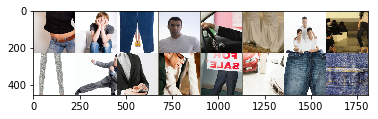

In [4]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()
    if title is not None:
        plt.title(title)
    plt.pause(0.01)
inputs, classes = next(iter(dataloader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes] )

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3,16,kernel_size=5,padding=2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2),
                                    nn.Dropout(0.5))
        self.layer2 = nn.Sequential(nn.Conv2d(16,32,kernel_size=5,padding=2),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2),
                                    nn.Dropout(0.5))
        self.layer3 = nn.Sequential(nn.Conv2d(32,64,kernel_size=5,padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2),
                                    nn.Dropout(0.5))
        self.fc1 = nn.Linear(28*28*64,1024)
        self.fc2 = nn.Linear(1024,1024)
        self.fc3 = nn.Linear(1024,2)
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
#         print(out.size())
#         print(out.size(0))
        out = out.view(out.size(0),-1)
#         print(out.size())
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [7]:
learning_rate = 0.00001
total_step = 5000
net = CNN()
net.cuda()
net.load_state_dict(torch.load('model.pkl'))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
logger = Logger('./logs1')

data_iter = iter(dataloader)
iter_per_epoch = len(dataloader)

In [8]:
for step in range(total_step):
    if (step+1)%iter_per_epoch:
        data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images, labels = Variable(images).cuda(), Variable(labels).cuda()
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    _, argmax = torch.max(outputs, 1)
    accuracy = (labels == argmax.squeeze()).float().mean()
    if (step+1) % 100 == 0:
        print ('Step [%d/%d], Loss: %.4f, Acc: %.4f' 
               %(step+1, total_step, loss.data[0], accuracy.data[0]))

        #============ TensorBoard logging ============#
        # (1) Log the scalar values
        info = {
            'loss': loss.data[0],
            'accuracy': accuracy.data[0]
        }

        for tag, value in info.items():
            logger.scalar_summary(tag, value, step+1)

Step [100/5000], Loss: 0.4887, Acc: 0.7500
Step [200/5000], Loss: 0.8385, Acc: 0.6875
Step [300/5000], Loss: 0.5029, Acc: 0.6875
Step [400/5000], Loss: 0.4923, Acc: 0.8125
Step [500/5000], Loss: 0.5026, Acc: 0.6875
Step [600/5000], Loss: 0.2820, Acc: 1.0000
Step [700/5000], Loss: 0.4147, Acc: 0.9375
Step [800/5000], Loss: 0.3311, Acc: 0.8125
Step [900/5000], Loss: 0.4113, Acc: 0.6875
Step [1000/5000], Loss: 0.4281, Acc: 0.8125
Step [1100/5000], Loss: 0.6400, Acc: 0.6875
Step [1200/5000], Loss: 0.6397, Acc: 0.7500
Step [1300/5000], Loss: 0.4462, Acc: 0.8125
Step [1400/5000], Loss: 0.4478, Acc: 0.8125
Step [1500/5000], Loss: 0.4601, Acc: 0.8750
Step [1600/5000], Loss: 0.8851, Acc: 0.7500
Step [1700/5000], Loss: 0.7414, Acc: 0.7500
Step [1800/5000], Loss: 0.2390, Acc: 1.0000
Step [1900/5000], Loss: 0.3962, Acc: 0.8125
Step [2000/5000], Loss: 0.4497, Acc: 0.8125
Step [2100/5000], Loss: 0.2703, Acc: 0.8750
Step [2200/5000], Loss: 0.7427, Acc: 0.8125
Step [2300/5000], Loss: 0.4275, Acc: 0.87

In [12]:
correct = 0
total = 0
for images, labels in dataloader:
    images = Variable(images.cuda())
    net.eval()
    outputs = net(images)
#     print(outputs.data)
    _, predicted = torch.max(outputs.data, 1)
#     print(predicted)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()
    
print('Accuracy of the network on the train images: %d %%' % (100*correct/total))

Accuracy of the network on the train images: 81 %


In [11]:
torch.save(net.state_dict(),'model_update.pkl')

In [90]:
cnn = CNN()
cnn.cuda()



CNN (
  (layer1): Sequential (
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Dropout (p = 0.5)
  )
  (layer2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Dropout (p = 0.5)
  )
  (layer3): Sequential (
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Dropout (p = 0.5)
  )
  (fc1): Linear (50176 -> 1024)
  (fc2): Linear (1024 -> 1024)
  (fc3): Linear (1024 -> 2)
)

In [91]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
logger = Logger('./logs')

data_iter = iter(dataloader)
iter_per_epoch = len(dataloader)

In [92]:
for step in range(total_step):
    if (step+1)%iter_per_epoch:
        data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images, labels = Variable(images).cuda(), Variable(labels).cuda()
    optimizer.zero_grad()
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    _, argmax = torch.max(outputs, 1)
    accuracy = (labels == argmax.squeeze()).float().mean()
    if (step+1) % 100 == 0:
        print ('Step [%d/%d], Loss: %.4f, Acc: %.4f' 
               %(step+1, total_step, loss.data[0], accuracy.data[0]))

        #============ TensorBoard logging ============#
        # (1) Log the scalar values
        info = {
            'loss': loss.data[0],
            'accuracy': accuracy.data[0]
        }

        for tag, value in info.items():
            logger.scalar_summary(tag, value, step+1)

Step [100/10000], Loss: 0.7420, Acc: 0.5000
Step [200/10000], Loss: 0.7436, Acc: 0.5000
Step [300/10000], Loss: 0.7268, Acc: 0.2500
Step [400/10000], Loss: 0.8524, Acc: 0.5625
Step [500/10000], Loss: 0.6047, Acc: 0.6250
Step [600/10000], Loss: 0.5340, Acc: 0.8750
Step [700/10000], Loss: 0.5981, Acc: 0.7500
Step [800/10000], Loss: 0.6607, Acc: 0.6250
Step [900/10000], Loss: 0.6045, Acc: 0.5000
Step [1000/10000], Loss: 0.6128, Acc: 0.6250
Step [1100/10000], Loss: 0.7059, Acc: 0.5625
Step [1200/10000], Loss: 0.7798, Acc: 0.5000
Step [1300/10000], Loss: 0.6767, Acc: 0.5625
Step [1400/10000], Loss: 0.7159, Acc: 0.5000
Step [1500/10000], Loss: 0.6958, Acc: 0.5000
Step [1600/10000], Loss: 0.7769, Acc: 0.6250
Step [1700/10000], Loss: 0.6869, Acc: 0.6250
Step [1800/10000], Loss: 1.2373, Acc: 0.3750
Step [1900/10000], Loss: 0.5725, Acc: 0.6250
Step [2000/10000], Loss: 1.1045, Acc: 0.5000
Step [2100/10000], Loss: 0.6127, Acc: 0.6875
Step [2200/10000], Loss: 0.5005, Acc: 0.8125
Step [2300/10000], 

In [94]:
correct = 0
total = 0
for images, labels in dataloader:
    images = Variable(images.cuda())
    cnn.eval()
    outputs = cnn(images)
#     print(outputs.data)
    _, predicted = torch.max(outputs.data, 1)
#     print(predicted)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()
    
print('Accuracy of the network on the train images: %d %%' % (100*correct/total))

Accuracy of the network on the train images: 77 %


In [95]:
torch.save(cnn.state_dict(),'model.pkl')